In [1]:
#!/usr/bin/env python3
import logging
import os
import subprocess
import time
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, CubicSpline as spline
from sympy import I
import vmec
from mpi4py import MPI

from simsopt.mhd import Vmec, Boozer
from neat.fields import Simple, StellnaQS, Vmec as Vmec_NEAT
from neat.tracing import ChargedParticle, ParticleOrbit

Trace the orbit of a single particle in a
quasisymmetric stellarator using Near Axis and VMEC   

Creating Boozer class for vmec_final
Defining surfaces where to compute Boozer coordinates
 booz_surfaces=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]
Running BOOZ_XFORM
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
Read ns=32, mpol=5, ntor=5, mnmax=50, mnmax_nyq=128
compute_surfs (0-based indices):  0 1 3 4 6 7 9 10 12 13 15 17 18 20 21 23 24 26 27 29
Initializing with mboz=64, nboz=64
ntheta = 258, nzeta = 258, # threads = 8
                   |        outboard (theta=0)      |      inboard (theta=pi)      |
thread js_b js zeta| |B|input  |B|Boozer    Error   | |B|input  |B|Boozer    Error |
------------------------------------------------------------------------------------
   5    14  21   0  2.394e+00  2.394e+00  1.317e-14  2.842e+00  2.842e+00  2.016e-14
                pi  2.840e+00  2.840e+00  2.345e-15  2.394e+00  2.394e+00  2.207e-14
   6    16  24   0  2.381e+00  2.381e+00  1.1

ValueError: `y` must contain only finite values.

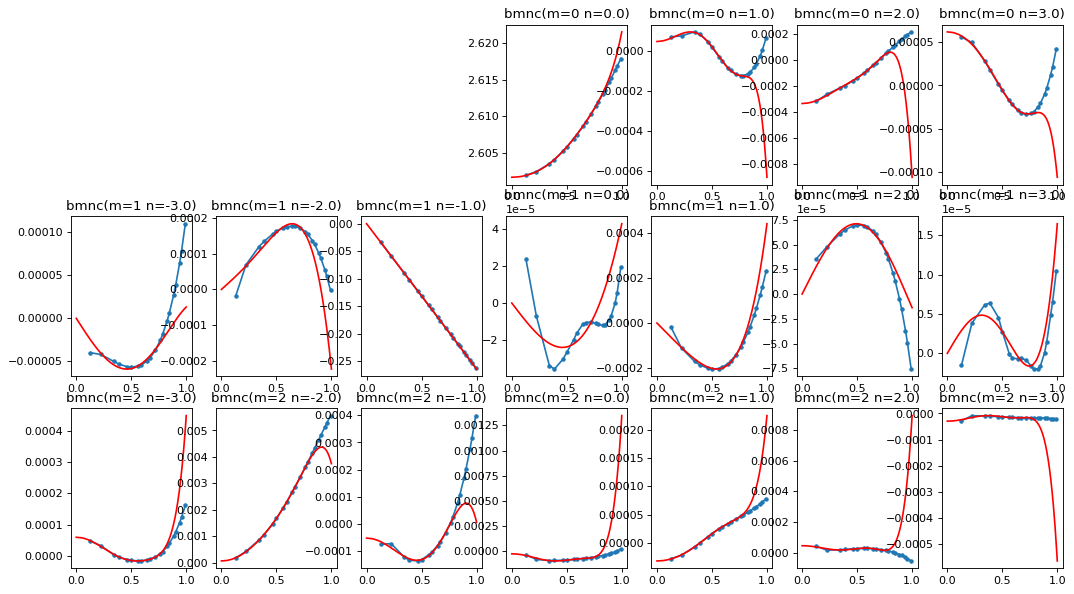

In [2]:
nfp=4
step_i=0.3
s_initials = np.round(np.arange(0.1,0.8,step_i), 2) # psi/psi_a for vmec
s_boundaries = np.round(np.arange(1,1.05,0.65),2)
# theta_initials=np.round(np.arange(0,2*np.pi,2*np.pi/5), 2)         # initial poloidal angle (vartheta=theta_Boozer - N phi_Boozer)
# phi_initials=np.round(np.arange(0,2*np.pi/nfp,2*np.pi/nfp/4), 2)    # initial toroidal angle (cylindrical on axis)
lambdas=np.round(np.arange(0.85,0.95,0.7), 2) # = mu * B0 / energy
theta_initials=[0]
phi_initials=[0]
# QA -> (theta, phi)= (0,0), (3.77,0)
# QH -> (theta, phi)= (0,0.94), (0.79,0.3), (1.26,0.93)
g_orbits=[]
g_orbits_vmec=[]
g_orbits_desc=[]
g_orbits_simple=[]
cntr_total=np.zeros((lambdas.size,s_boundaries.size))
cntr_lost_neat=np.zeros_like(cntr_total)
cntr_lost_vmec=np.zeros_like(cntr_total)
cntr_actual_lost=np.zeros_like(cntr_total)
cntr_nan=np.zeros_like(cntr_total)

max_s_for_fit = 0.6
boozxform_nsurfaces = 20
boozer_mpol = 64
boozer_ntor = 64
N_phi = 151
max_n_to_plot = 3
show_fit_plot = True
plot_boozer = True


for j in np.arange(s_boundaries.size):
    
    B0 = 5.3267         # Tesla, magnetic field on-axis (ARIES-CS)
    energy = 3.52e6     # electron-volt
    charge = 2          # times charge of proton
    mass = 4            # times mass of proton     
    vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
    nsamples = 10000     # resolution in time
    tfinal = 1e-4       # seconds
    constant_b20 =False # use a constant B20 (mean value) or the real function

    Rmajor_ARIES = 7.7495
    Rminor_ARIES = 1.7044
    r_avg=Rminor_ARIES*s_boundaries[j]
    N_phi = 151


    filename_vmec = f"input.preciseQH_new"
    wout_filename_vmec = f"wout_preciseQH_new_000_000000.nc"
    
    vmec=Vmec(filename=filename_vmec, verbose=False)
    vmec.run()
    g_field_vmec = Vmec_NEAT(wout_filename=wout_filename_vmec,maximum_s=1)
    
    print('Creating Boozer class for vmec_final')
    b1 = Boozer(vmec, mpol=boozer_mpol, ntor=boozer_ntor)
    print('Defining surfaces where to compute Boozer coordinates')
    booz_surfaces = np.linspace(0,1,boozxform_nsurfaces,endpoint=False)
    print(f' booz_surfaces={booz_surfaces}')
    b1.register(booz_surfaces)
    print('Running BOOZ_XFORM')
    b1.run()
    
    g_field = StellnaQS(rc=vmec.wout.raxis_cc,zs=-vmec.wout.zaxis_cs,etabar=1,nphi=N_phi,nfp=vmec.wout.nfp)

    nNormal = g_field.iotaN - g_field.iota
    # Prepare coordinates for fit
    s_full = np.linspace(0,1,b1.bx.ns_in)
    ds = s_full[1] - s_full[0]
    #s_half = s_full[1:] - 0.5*ds
    s_half = s_full[b1.bx.compute_surfs+1] - 0.5*ds
    mask = s_half < max_s_for_fit
    s_fine = np.linspace(0,1,400)
    sqrts_fine = s_fine
    phi = np.linspace(0,2*np.pi / vmec.wout.nfp, N_phi)
    B0  = np.zeros(N_phi)
    B1s = np.zeros(N_phi)
    B1c = np.zeros(N_phi)
    B20 = np.zeros(N_phi)
    B2s = np.zeros(N_phi)
    B2c = np.zeros(N_phi)
    # Perform fit
    numRows=3
    numCols=max_n_to_plot*2+1
    fig=plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
    for jmn in range(len(b1.bx.xm_b)):
        m = b1.bx.xm_b[jmn]
        n = b1.bx.xn_b[jmn] / vmec.wout.nfp
        if m>2:
            continue
        doplot = (np.abs(n) <= max_n_to_plot) & show_fit_plot
        row = m
        col = n+max_n_to_plot
        if doplot:
            plt.subplot(int(numRows),int(numCols),int(row*numCols + col + 1))
            plt.plot(np.sqrt(s_half), b1.bx.bmnc_b[jmn, :],'.-')
            # plt.xlabel(r'$\sqrt{s}$')
            plt.title('bmnc(m='+str(m)+' n='+str(n)+')')
        if m==0:
            # For m=0, fit a polynomial in s (not sqrt(s)) that does not need to go through the origin.
            degree = 4
            p = np.polyfit(s_half[mask], b1.bx.bmnc_b[jmn, mask], degree)
            B0 += p[-1] * np.cos(n*vmec.wout.nfp*phi)
            B20 += p[-2] * np.cos(2*n*vmec.wout.nfp*phi)
            if doplot:
                plt.plot(np.sqrt(s_fine), np.polyval(p, s_fine),'r')
        if m==1:
            # For m=1, fit a polynomial in sqrt(s) to an odd function
            x1 = np.sqrt(s_half[mask])
            y1 = b1.bx.bmnc_b[jmn,mask]
            x2 = np.concatenate((-x1,x1))
            y2 = np.concatenate((-y1,y1))
            degree = 5
            p = np.polyfit(x2,y2, degree)
            B1c += p[-2] * (np.sin(n*vmec.wout.nfp*phi) * np.sin(nNormal*phi) + np.cos(n*vmec.wout.nfp*phi) * np.cos(nNormal*phi))
            B1s += p[-2] * (np.sin(n*vmec.wout.nfp*phi) * np.cos(nNormal*phi) - np.cos(n*vmec.wout.nfp*phi) * np.sin(nNormal*phi))
            if doplot:
                plt.plot(sqrts_fine, np.polyval(p, sqrts_fine),'r')
        if m==2:
            # For m=2, fit a polynomial in s (not sqrt(s)) that does need to go through the origin.
            x1 = s_half[mask]
            y1 = b1.bx.bmnc_b[jmn,mask]
            degree = 4
            p = np.polyfit(x1,y1, degree)
            B2c += p[-2] * (np.sin(2*n*vmec.wout.nfp*phi) * np.sin(2*nNormal*phi) + np.cos(2*n*vmec.wout.nfp*phi) * np.cos(2*nNormal*phi))
            B2s += p[-2] * (np.sin(2*n*vmec.wout.nfp*phi) * np.cos(2*nNormal*phi) - np.cos(2*n*vmec.wout.nfp*phi) * np.sin(2*nNormal*phi))
            if doplot:
                plt.plot(np.sqrt(s_fine), np.polyval(p, s_fine),'r')
    plt.savefig(os.path.join('results','nearaxis_fit.pdf'))
    # if show:
    #     plt.show()
    # plt.close()
    # Convert expansion in sqrt(s) to an expansion in r
    BBar = np.mean(B0)
    Psi_a = np.abs(vmec.wout.phi[-1])
    sqrt_s_over_r = np.sqrt(np.pi * BBar / Psi_a)
    B1s *= -sqrt_s_over_r
    B1c *= -sqrt_s_over_r
    B20 *= sqrt_s_over_r*sqrt_s_over_r
    B2c *= sqrt_s_over_r*sqrt_s_over_r
    B2s *= sqrt_s_over_r*sqrt_s_over_r
    print('Plotting B0, B1 and B2')
    eta_bar = np.mean(B1c) / BBar
    r_boundary  = np.sqrt(Psi_a/(np.pi*BBar))
    p2 = 0
    I2 = 0
    sigma0 = 0

    g_field = StellnaQS(rc=vmec.wout.raxis_cc,zs=-vmec.wout.zaxis_cs,etabar=eta_bar,nphi=N_phi,nfp=vmec.wout.nfp,B0=BBar,sigma0=sigma0, I2=I2, B2c=np.mean(B2c), order='r3', p2=p2)

    nu_array = g_field.varphi - g_field.phi
    nu_spline_of_varphi = spline(
        np.append(g_field.varphi, 2 * np.pi / g_field.nfp),
        np.append(nu_array, nu_array[0]),
        bc_type="periodic",
    )

    g_field_simple = Simple(wout_filename=wout_filename_vmec, ns_s=5, ns_tp=5, nsamples=1000)


    for i in np.arange(lambdas.size):
        for s_initial in s_initials:
            for theta_initial in theta_initials:
                for phi_initial in phi_initials:
                    
                    g_particle = ChargedParticle(
                        r_initial = r_avg*np.sqrt(s_initial),#s=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
                        theta_initial = theta_initial-(g_field.iota-g_field.iotaN)*phi_initial,
                        phi_initial = phi_initial,    
                        energy = energy,
                        Lambda = lambdas[i],
                        charge = charge,
                        mass = mass,
                        vpp_sign = vpp_sign,
                    )
                    
                    phi0 = phi_initial - nu_spline_of_varphi(phi_initial)
                    phi_VMEC=g_field.to_RZ([[r_avg*np.sqrt(s_initial),theta_initial,phi0]])[2][0]
                    
                    g_particle_vmec = ChargedParticle(
                        r_initial = s_initial,
                        theta_initial = np.pi-(theta_initial),     
                        phi_initial = phi_VMEC,    
                        energy = energy,
                        Lambda = lambdas[i],
                        charge = charge,
                        mass = mass,
                        vpp_sign = vpp_sign,
                    )
                    g_particle_simple = ChargedParticle(
                        r_initial=s_initial,
                        theta_initial= -(np.pi-theta_initial),
                        phi_initial= -phi_VMEC,
                        energy=energy,
                        Lambda=lambdas[i],
                        charge=charge,
                        mass=mass,
                        vpp_sign= vpp_sign,
                    )

                    g_orbit = ParticleOrbit(g_particle, g_field, nsamples = nsamples, 
                        tfinal = tfinal, constant_b20 = constant_b20)

                    
                    g_orbit_vmec = ParticleOrbit(g_particle_vmec, g_field_vmec, nsamples = nsamples,
                        tfinal = tfinal, constant_b20 = constant_b20)
                    
                    g_orbit_simple = ParticleOrbit(g_particle_simple, g_field_simple, nsamples=nsamples, 
                        tfinal=tfinal)
                    


                    #Correcting signs in SIMPLE to match others
                    g_orbit_simple.theta_pos  = -g_orbit_simple.theta_pos
                    g_orbit_simple.varphi_pos = -g_orbit_simple.varphi_pos
                    g_orbit_simple.thetadot   = -g_orbit_simple.thetadot
                    g_orbit_simple.varphidot  = -g_orbit_simple.varphidot
                    g_orbit_simple.rpos_cylindrical[1] = -g_orbit_simple.rpos_cylindrical[1]
                    g_orbit_simple.rpos_cylindrical[2] = -g_orbit_simple.rpos_cylindrical[2]
                    g_orbit_simple.rpos_cartesian[1]= -g_orbit_simple.rpos_cartesian[1]
                    g_orbit_simple.time = g_orbit_simple.time - g_orbit_simple.time[0]

                    #Interpolating variables in SIMPLE to match times

                    g_orbit_simple.rpos_cylindrical= interp1d(g_orbit_simple.time, g_orbit_simple.rpos_cylindrical, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.rpos_cartesian= interp1d(g_orbit_simple.time, g_orbit_simple.rpos_cartesian, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.r_pos = interp1d(g_orbit_simple.time, g_orbit_simple.r_pos, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.theta_pos=interp1d(g_orbit_simple.time, g_orbit_simple.theta_pos, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.varphi_pos=interp1d(g_orbit_simple.time, g_orbit_simple.varphi_pos, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.rdot = interp1d(g_orbit_simple.time, g_orbit_simple.rdot, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.thetadot=interp1d(g_orbit_simple.time, g_orbit_simple.thetadot, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.varphidot=interp1d(g_orbit_simple.time, g_orbit_simple.varphidot, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.energy_parallel = interp1d(g_orbit_simple.time, g_orbit_simple.energy_parallel, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.energy_perpendicular = interp1d(g_orbit_simple.time, g_orbit_simple.energy_perpendicular, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.total_energy =g_orbit_simple.energy_parallel + g_orbit_simple.energy_perpendicular
                    g_orbit_simple.magnetic_field_strength = interp1d(g_orbit_simple.time, g_orbit_simple.magnetic_field_strength, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.v_parallel = interp1d(g_orbit_simple.time, g_orbit_simple.v_parallel, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.vparalleldot = interp1d(g_orbit_simple.time, g_orbit_simple.vparalleldot, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)
                    g_orbit_simple.p_phi= interp1d(g_orbit_simple.time, g_orbit_simple.p_phi, 
                    assume_sorted=True, bounds_error=False, fill_value='extrapolate')(g_orbit.time)

                    g_orbit_simple.time = g_orbit.time
                    
                    g_orbits.append(g_orbit)
                    g_orbits_vmec.append(g_orbit_vmec)
                    g_orbits_simple.append(g_orbit_simple)



In [ ]:
if not os.path.exists('A=' + str(Rmajor_ARIES/r_avg)):
    os.mkdir('A=' + str(Rmajor_ARIES/r_avg))
norms_r_pos=[]
norms_r_pos_filt=[]
plt.figure(figsize=(10, 6))
for i in np.arange(0,6,1):  
    s_i=np.round(0.1 + step_i*i,2)
    if not os.path.exists('A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(s_i)):
        os.mkdir('A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(s_i))
    norm_r_pos = (g_orbits[i].r_pos/(r_avg))**2
    # peaks, _= signal.find_peaks(norm_r_pos,distance=(4/100)*g_orbits[i].time.size)
    # valleys,_= signal.find_peaks(-norm_r_pos,distance=(4/100)*g_orbits[i].time.size)

    # if peaks.size>valleys.size: peaks=peaks[:valleys.size]
    # else: valleys=valleys[:peaks.size]

    # peaks2, _= signal.find_peaks(g_orbits_desc[i].r_pos,distance=(8/100)*g_orbits[i].time.size)
    # valleys2,_= signal.find_peaks(-g_orbits_desc[i].r_pos,distance=(8/100)*g_orbits[i].time.size)

    # if peaks2.size>valleys2.size: peaks2=peaks2[:valleys2.size]
    # else: valleys2=valleys2[:peaks2.size]

    # peaks3, _= signal.find_peaks(g_orbits_vmec[i].r_pos,distance=(8/100)*g_orbits[i].time.size)
    # valleys3,_= signal.find_peaks(-g_orbits_vmec[i].r_pos,distance=(8/100)*g_orbits[i].time.size)

    # if peaks3.size>valleys3.size: peaks3=peaks3[:valleys3.size]
    # else: valleys3=valleys3[:peaks3.size]    

    # fs = 1 / ( g_orbits[i].time[1] - g_orbits[i].time[0] )  # Sampling frequency
    # cutoff = 1e4                     # Frequency cutoff value in Hz

    # norm_r_pos_filt = butter_lowpass_filter(norm_r_pos, cutoff, fs)
    # r_pos_filt2 = butter_lowpass_filter2(g_orbits_desc[i].r_pos, cutoff, fs)
    # r_pos_filt3 = butter_lowpass_filter2(g_orbits_vmec[i].r_pos, cutoff, fs)

    # diff_s_filt2=norm_r_pos_filt - r_pos_filt2
    # diff_s_filt3=norm_r_pos_filt - r_pos_filt3
    # plt.plot(g_orbits_vmec[i].time*1e6, np.abs(diff_s_filt2), label='DESC s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits_vmec[i].time*1e6, np.abs(diff_s_filt3), label='VMEC s_i='+str(np.round(0.1 + step_i*i,2)))

    # avg_time=(g_orbits[i].time[peaks]+g_orbits[i].time[valleys])*1e6/2
    # avg_time2=(g_orbits_desc[i].time[peaks2]+g_orbits_desc[i].time[valleys2])*1e6/2
    # avg_time3=(g_orbits_vmec[i].time[peaks3]+g_orbits_vmec[i].time[valleys3])*1e6/2

    # plt.plot(avg_time-avg_time[0]/2, norm_r_pos[peaks]-norm_r_pos[valleys],label='NA s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(avg_time2-avg_time2[0]/2, g_orbits_desc[i].r_pos[peaks2]-g_orbits_desc[i].r_pos[valleys2],label='DESC s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(avg_time3-avg_time3[0]/2, g_orbits_vmec[i].r_pos[peaks3]-g_orbits_vmec[i].r_pos[valleys3],label='VMEC s_i='+str(np.round(0.1 + step_i*i,2)))
    plt.rcParams["figure.facecolor"] = "w"
    plt.plot(g_orbits_vmec[i].time*1e6, g_orbits_vmec[i].r_pos,label='vmec s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits_vmec[i].time[valleys2]*1e6, g_orbits_vmec[i].r_pos[valleys2],label='vmec s_i='+str(np.round(0.1 + step_i*i,2)),linestyle='None',marker='.')
    # plt.plot(g_orbits_desc[i].time*1e6, g_orbits_desc[i].r_pos,label='desc s_i='+str(np.round(0.1 + step_i*i,2)))
    plt.plot(g_orbits_simple[i].time*1e6, g_orbits_simple[i].r_pos,label='simple s_i='+str(np.round(0.1 + step_i*i,2)))
    plt.plot(g_orbits[i].time*1e6, norm_r_pos,label='qsc s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.show()
    # plt.plot(g_orbits_simple[i].time*1e6, np.pi + g_orbits_simple[i].theta_pos,label='simple s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits[i].time*1e6, g_orbits[i].theta_pos,label=' s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.show()
    # plt.plot(g_orbits_simple[i].time*1e6, g_orbits_simple[i].varphi_pos,label='simple s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.plot(g_orbits[i].time*1e6, g_orbits[i].varphi_pos,label=' s_i='+str(np.round(0.1 + step_i*i,2)))
    # plt.show()
    # plt.plot(g_orbits[i].time*1e6, g_orbits[i].rpos_cylindrical[0],label=' s_i='+str(np.round(0.1 + step_i*i,2)),linestyle='None',marker='.')
    # plt.plot(g_orbits_simple[i].time*1e6, g_orbits_simple[i].rpos_cylindrical[0],label='simple s_i='+str(np.round(0.1 + step_i*i,2)),linestyle='None',marker='.')
    # plt.plot(g_orbits_simple[i].time*1e6, 100*(g_orbits_simple[i].rpos_cylindrical[0]-g_orbits[i].rpos_cylindrical[0])/g_orbits[i].rpos_cylindrical[0],label='simple s_i='+str(np.round(0.1 + step_i*i,2)),linestyle='None',marker='.')

    plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
    plt.xlabel(r't ($\mu$s)')
    # plt.xlim(60,61)
    # plt.ylim(0.09,0.12)
    plt.savefig('A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/r_pos',transparent=False)
    plt.show()
    print('NEAT')
    g_orbits[i].plot_orbit_contourB(savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/B_neat')
    print('VMEC')
    g_orbits_vmec[i].plot_orbit_contourB(savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/B_vmec')
    # print('DESC')
    # g_orbits_desc[i].plot_orbit_contourB()
    print('SIMPLE')
    g_orbits_simple[i].plot_orbit_contourB(savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/B_simple')
    print('NEAT-VMEC')
    g_orbits[i].plot_diff_boozer(g_orbits_vmec[i],r_minor=r_avg,savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_booz_neat_vmec')
    # print('NEAT-DESC')
    # g_orbits[i].plot_diff_boozer(g_orbits_desc[i],r_minor=r_avg)
    print('NEAT-SIMPLE')
    g_orbits[i].plot_diff_boozer(g_orbits_simple[i],r_minor=r_avg,savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_booz_neat_simple')
    print('VMEC-SIMPLE')
    g_orbits_vmec[i].plot_diff_boozer(g_orbits_simple[i],r_minor=1,savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_booz_vmec_simple')
    print('NEAT-VMEC')
    g_orbits[i].plot_diff_cyl(g_orbits_vmec[i],savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_cyl_neat_vmec')
    # print('NEAT-DESC')
    # g_orbits[i].plot_diff_cyl(g_orbits_desc[i])
    print('NEAT-SIMPLE')
    g_orbits[i].plot_diff_cyl(g_orbits_simple[i],savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_cyl_neat_simple')
    print('VMEC-SIMPLE')
    g_orbits_vmec[i].plot_diff_cyl(g_orbits_simple[i],savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/diff_cyl_vmec_simple')
    print('NEAT')
    g_orbits[i].plot(savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/param_neat')
    print('VMEC')
    g_orbits_vmec[i].plot(savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/param_vmec')
    # print('DESC')
    # g_orbits_desc[i].plot()
    print('SIMPLE')
    g_orbits_simple[i].plot(savefig='A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_i)+'/param_simple')
    # plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)

    # g_orbits[i].plot_orbit_3d(show=True, r_surface=r_avg, savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[1]) + '_s_i=' + str(s_initial) + \
    #     '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_neat_orbit.png')
    # g_orbits_vmec[i].plot_orbit_3d(show=True,savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[1]) + '_s_i=' + str(s_initial) + \
    #     '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_vmec_orbit.png')
    # g_orbits_desc[i].plot_orbit_3d(show=True,savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[1]) + '_s_i=' + str(s_initial) + \
    #     '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_vmec_orbit.png')
    # try:
    #     max=np.minimum(avg_time[-1],avg_time2[-1],avg_time3[-1])
    #     plt.xlim(0,max)
    # except:
    #     print('No radial oscillation')
    # g_orbits[i].plot_orbit_contourB(show=True, savefig='s_b=' + str(s_boundaries[0]) + '/s_b=' + str(s_boundaries[0]) + '_lambda=' + str(lambdas[0]) + '_s_i=' + str(s_initial) + \
    #      '_theta=' + str(theta_initial) + '_phi=' + str(phi_initial) + '_neat_orbit.png')
    


# plt.xlabel(r't ($\mu$s)')
# plt.ylabel(r"Radial oscillation amplitude")
# plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
# # plt.ylabel(r'Average radial difference')
# # plt.legend(fontsize='small', loc=(0.6,0.1),ncol=2)
# # plt.ylabel(r"s")
# # plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
# plt.show()
